<a href="https://colab.research.google.com/github/janchorowski/dl_uwr/blob/summer2021/Assignments/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5

**Submission deadlines:**
- get at least 4 points by Tuesday, 8.06 
- remaining points: last lab session of the semester

**Points:** Aim to get 12 out of 16 possible points.


## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

We provide a starter code, however, you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Problem 1: Generating 2 Moons data
Consider the 2D moons dataset generated in the starter code below. 

Train the following models: VAE, GAN, RealNVP. 

For each model visualize how the latent space is transformed into data points. Train a model with 2D latent space. Then whenever applicable:
1. Plot the data points along with a grid, then plot latent encodings of the data and the grid.
2. Generate latent encodings and a grid in latent space. Then sample data points based on the generated latent space and grid. Plot them in the data space.

Hint: for better visual mapping between original and latent representations of the data, use color on the scatterplots.

## Tasks:
1. [4p] Variational Autoencoder (VAE)

  Please use the following probability distributions:
    
  $$
    \begin{split}
    p(z) &= \mathcal{N}(z; \mu=0, \sigma^2=1)  \\
    p(x | z) &= \mathcal{N}(x; \mu=x_{\mu}(z), \sigma^2=x_{\sigma^2})
    \end{split}
  $$

  where: $x_{\mu}(z)$ is computed by a small neural network and $x_{\sigma^2}$ is a learned parameter.

  **Answer these questions:**
  
  1. Write down the formula for the reconstruction loss. The variance appears in two terms, what is their function?

  2. The reconstruction loss may fall below zero. How is this possible? 

  Compare the operation of the VAE for 2 Moons with a few widths. How is the loss dependent on the width? Why?

2. [3p] Generative Adversarial Network (GAN)

  Please use either a standard normal distribution for the latent space or a uniform distribution.

  **Answer these questions:**
  - Is the GAN generating all possible samples? Is it concentrating more on some regions of the data space?

3. [3p] Normalizing Flow (Real NVP model).

  The goal of Normalizing Flows is to learn invertible transformation between complex data distribution and some simple one, i.e. multivariate isotropic Gaussian. Since the latter is continuous, and our dataset is finite (hence in fact forms a discrete distribution, because you can memorize all observed values), we need to perform *dequantization*, that is add random noise to data at every iteration to train the model on an infinite stream of data. This is especially important in Problem 2 when RealNVP is applied to the MNIST data.

    **Answer these questions:**
  - Scale the input data by 0.01. Why is the negative log-likelihood negative?
  - For a few 2 moon widths compare the negative log-likelihood of the data with the values obtained with the VAE and present results in a table. How do they compare? Please note, that GAN's do not return likelihood computation.


# Problem 2: Generating MNIST

Next, choose one of the generative models (VAE, RealNVP, or GAN) and do the following using the MNIST dataset:

##Tasks
1. [2p] Train the model. Visualize generated samples (and test/train data reconstructions if you chose VAE).

Please properly define $p(x|z)$: when using a VAE, you can binarize the data and predict binary variables. For RealNVP, you can normalize the data to the 0-1 range, and add uniform noise $[0,1/255]$ to dequantize intensity values. GAN does not assume an output probability distribution and you may use raw data.

2. [1p] Linearly interpolate between two points in the latent space. Generate images from them and intermediate points. 

3. [1p] Try a different interpolation method, i.e. instead of going in a straight line from one point to another, follow the spherical curve of prior Gaussian distribution.

4. [2p] It is sometimes desirable to make use of available labels to gain control over classes of generated samples. Create a conditional generative model of your choice by injecting one-hot embeddings into the proper component(s). An example is [Conditional GAN](https://arxiv.org/abs/1411.1784), and its idea is applicable to other methods.


# Starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose

device = "cuda"

## Data

In [2]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [2]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


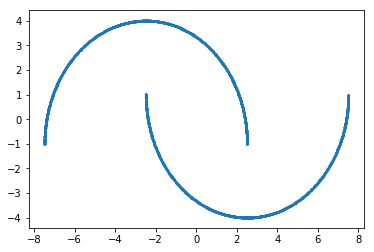

In [237]:
moons = generate_moons(width=.01)
moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

## VAE

In [64]:
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, in_dim),
        )

        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def forward(self, x):
        sampled_z, z_mu, z_log_var = self.encode(x)
        x_mu, x_log_var = self.decode(sampled_z)
        return x_mu, x_log_var, z_mu, z_log_var

    def encode(self, x):
        # Implement encoding procedure.
        # First, get z_mu and z_log_var from the encoder.
        # Second, compute z samples using the  the reparametrization trick.
        # TODO
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
        sampled_z = torch.randn(*z_mu.shape).to(device)*torch.exp(z_log_var)+z_mu
        return sampled_z, z_mu, z_log_var

    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

In [65]:
def gaussian_negative_log_likelihood(x, mu, log_var):
    """Compute N(x; mu=mu, sigma^2=exp(log_var)^2)."""
    #0.9189385332046727 = np.log(np.sqrt(np.pi*2))
    return log_var+0.9189385332046727+(x-mu)**2/(2*torch.exp(log_var)**2)


def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2):
    return (
        log_var2 - log_var1 + (log_var1.exp() + (mu1 - mu2) ** 2) / (log_var2.exp()) - 1
    ) / 2


def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negtive log-likelihood reconstruction loss:
        1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    return torch.sum(
            gaussian_negative_log_likelihood(real_x,predicted_x_mu,predicted_x_log_var),
    )/real_x.shape[1]
    


def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1).

    """
    return torch.sum(
        kullback_leibler_divergence_between_two_gaussians(z_mu, z_log_var,torch.zeros_like(z_mu),
                                                  torch.ones_like(z_log_var))
    )


In [66]:
hid_dim = 64
z_dim = 2
lr = 0.0006

vae = VAE(hid_dim=hid_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

Epoch: 0 loss: 15633.0609 recon_loss: 14965.4187 kl_loss: 667.6421 avg mean: 0.0899 avg std: 1.2093, time: 0.0561


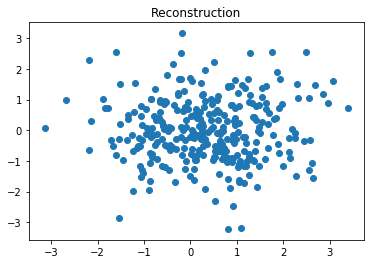

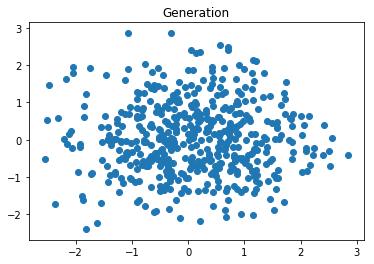

Epoch: 200 loss: 5397.5005 recon_loss: 3179.5757 kl_loss: 2217.9248 avg mean: 0.0213 avg std: 1.0030, time: 12.7989


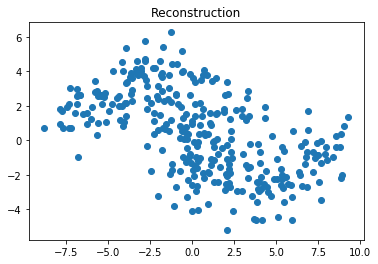

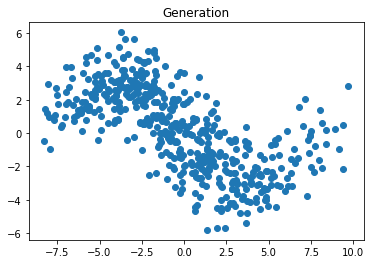

Epoch: 400 loss: 5345.1796 recon_loss: 3040.4532 kl_loss: 2304.7264 avg mean: 0.0531 avg std: 1.0136, time: 12.7980


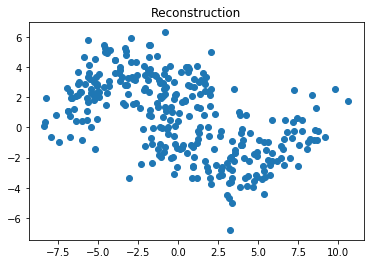

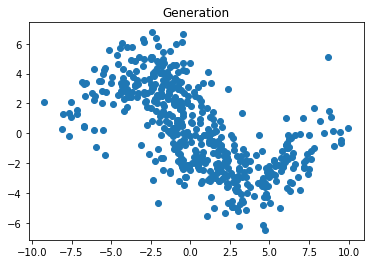

Epoch: 600 loss: 5200.6231 recon_loss: 2697.2149 kl_loss: 2503.4083 avg mean: 0.0049 avg std: 0.9784, time: 12.8486


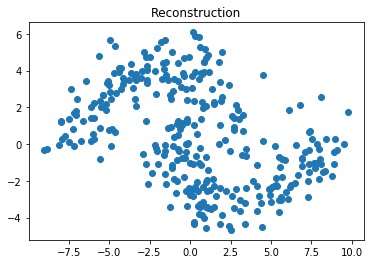

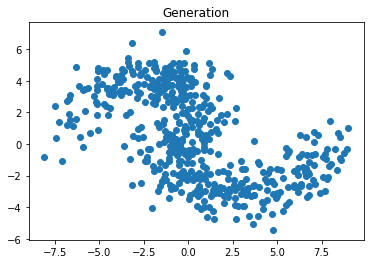

Epoch: 800 loss: 5067.4134 recon_loss: 2322.3187 kl_loss: 2745.0946 avg mean: -0.0239 avg std: 0.9894, time: 12.9113


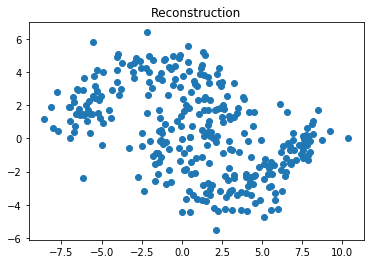

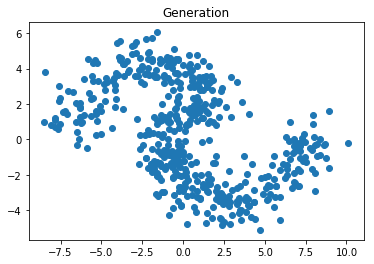

Epoch: 1000 loss: 5037.9667 recon_loss: 2170.9737 kl_loss: 2866.9930 avg mean: 0.0406 avg std: 0.9391, time: 12.7691


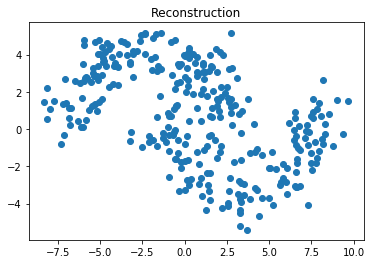

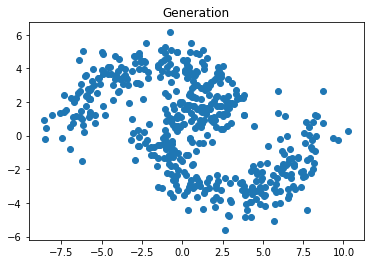

Epoch: 1200 loss: 4925.2924 recon_loss: 1930.0045 kl_loss: 2995.2879 avg mean: 0.0210 avg std: 0.9660, time: 12.7746


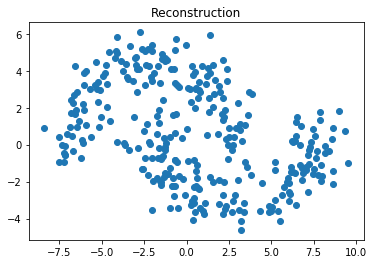

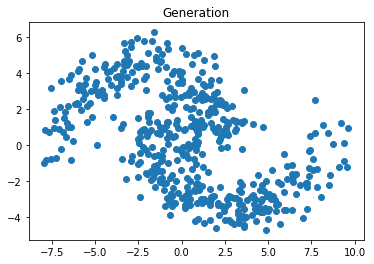

Epoch: 1400 loss: 4927.4834 recon_loss: 1877.6686 kl_loss: 3049.8149 avg mean: 0.0428 avg std: 0.9625, time: 12.8363


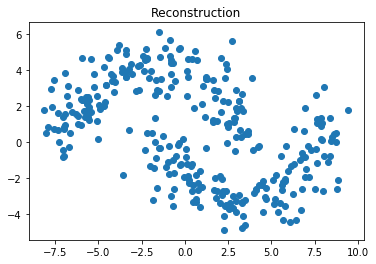

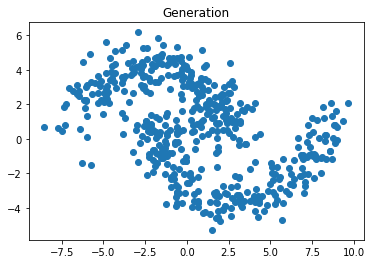

Epoch: 1600 loss: 4896.9259 recon_loss: 1789.6284 kl_loss: 3107.2975 avg mean: -0.0009 avg std: 0.9488, time: 12.8399


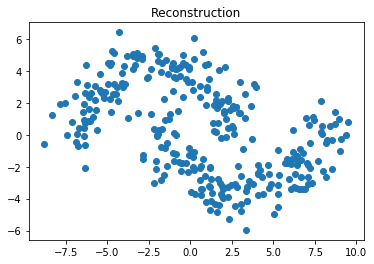

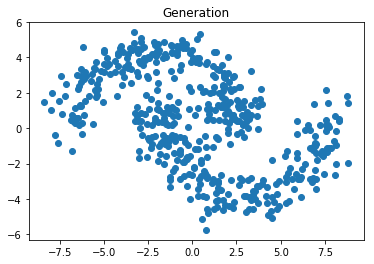

Epoch: 1800 loss: 4888.8912 recon_loss: 1793.1616 kl_loss: 3095.7296 avg mean: -0.0098 avg std: 0.9638, time: 12.8485


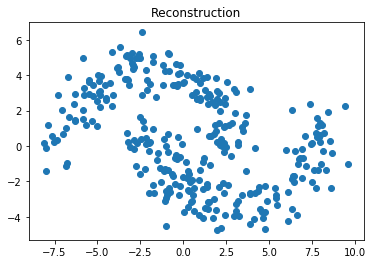

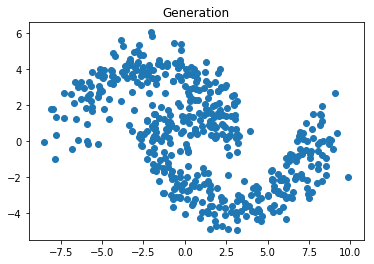

Epoch: 2000 loss: 4885.3418 recon_loss: 1776.2401 kl_loss: 3109.1017 avg mean: 0.0088 avg std: 0.9429, time: 12.8097


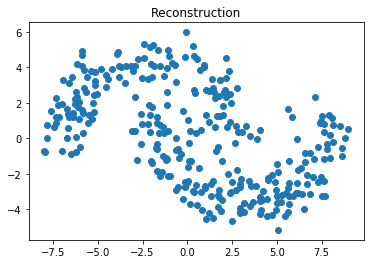

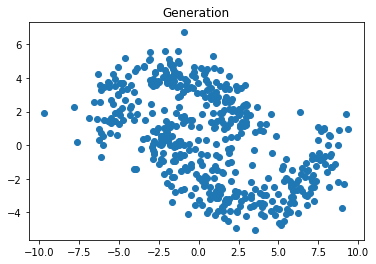

Epoch: 2200 loss: 4886.6805 recon_loss: 1777.0294 kl_loss: 3109.6511 avg mean: 0.0308 avg std: 0.9680, time: 12.7591


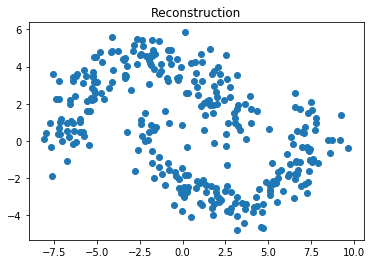

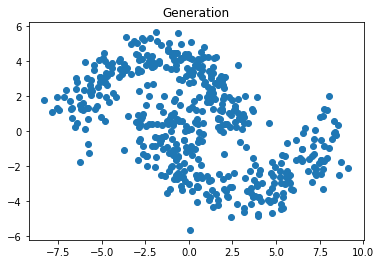

Epoch: 2400 loss: 4888.0959 recon_loss: 1776.0050 kl_loss: 3112.0909 avg mean: 0.0181 avg std: 0.9630, time: 12.8296


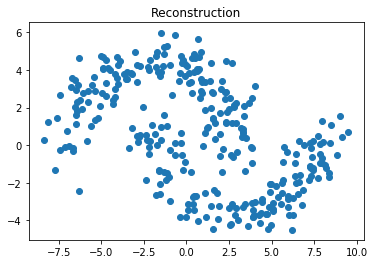

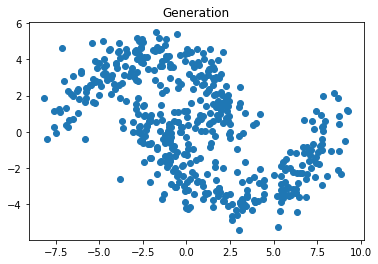

Epoch: 2600 loss: 4865.6895 recon_loss: 1727.6023 kl_loss: 3138.0872 avg mean: -0.0158 avg std: 0.9447, time: 12.7996


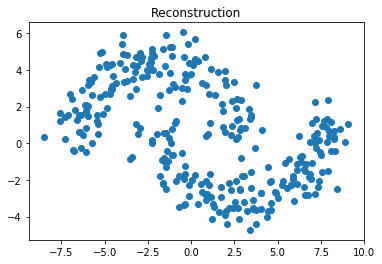

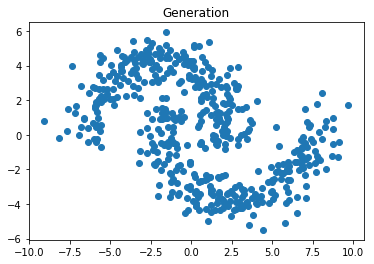

Epoch: 2800 loss: 4867.1575 recon_loss: 1745.5275 kl_loss: 3121.6300 avg mean: 0.0110 avg std: 0.9557, time: 12.9051


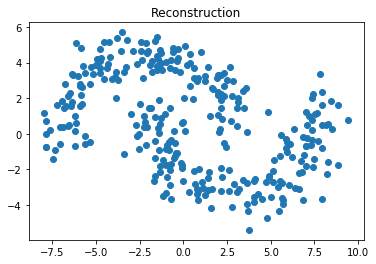

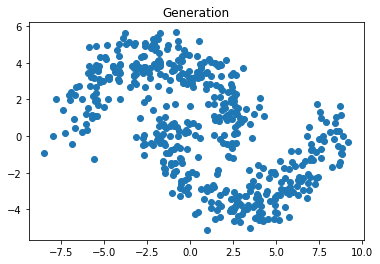

Epoch: 3000 loss: 4877.6482 recon_loss: 1725.8226 kl_loss: 3151.8256 avg mean: 0.0099 avg std: 0.9592, time: 12.8707


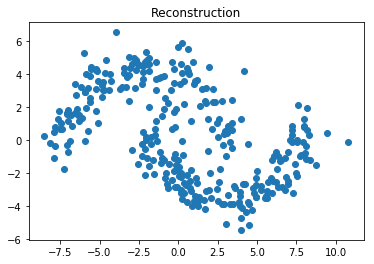

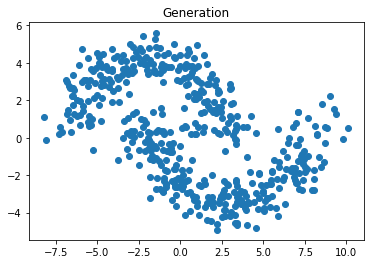

Epoch: 3200 loss: 4857.3282 recon_loss: 1731.0352 kl_loss: 3126.2930 avg mean: -0.0137 avg std: 0.9667, time: 12.7891


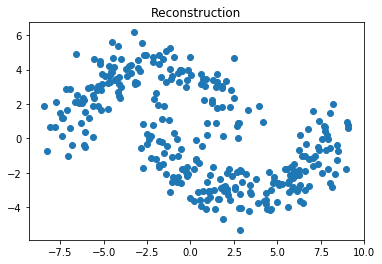

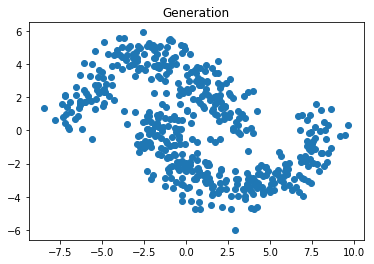

Epoch: 3400 loss: 4849.0226 recon_loss: 1733.9400 kl_loss: 3115.0827 avg mean: 0.0162 avg std: 0.9400, time: 12.8374


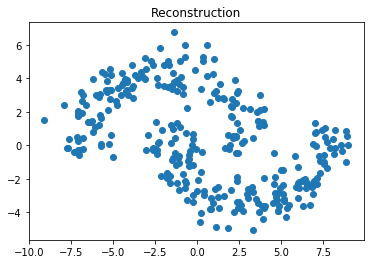

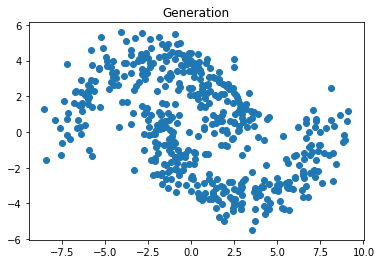

Epoch: 3600 loss: 4873.6346 recon_loss: 1743.5478 kl_loss: 3130.0868 avg mean: -0.0110 avg std: 0.9267, time: 12.8698


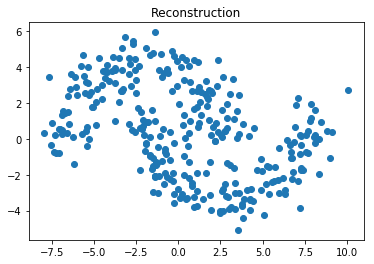

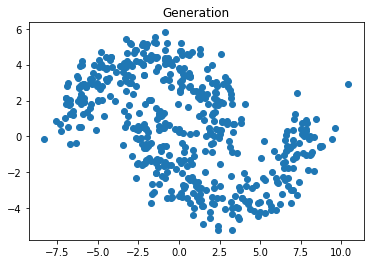

Epoch: 3800 loss: 4850.3290 recon_loss: 1725.6932 kl_loss: 3124.6357 avg mean: 0.0599 avg std: 0.9463, time: 12.8353


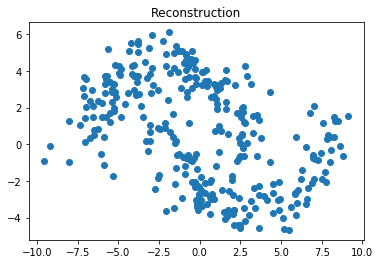

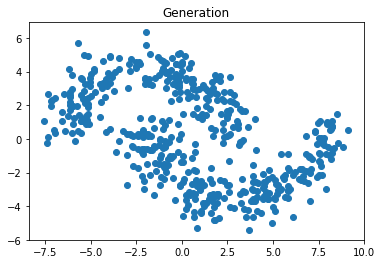

Epoch: 4000 loss: 4860.2580 recon_loss: 1715.2070 kl_loss: 3145.0511 avg mean: -0.0198 avg std: 0.9608, time: 12.8177


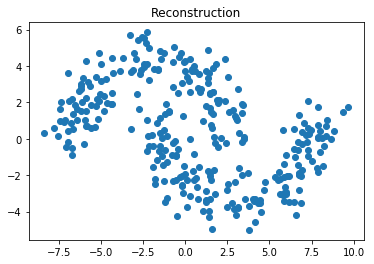

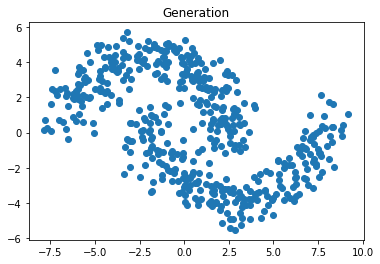

Epoch: 4200 loss: 4851.0209 recon_loss: 1707.2144 kl_loss: 3143.8065 avg mean: -0.0114 avg std: 0.9698, time: 12.8023


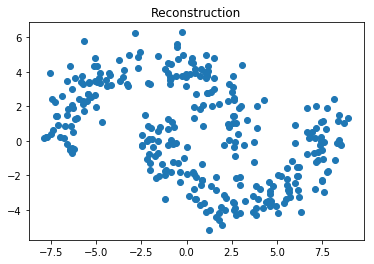

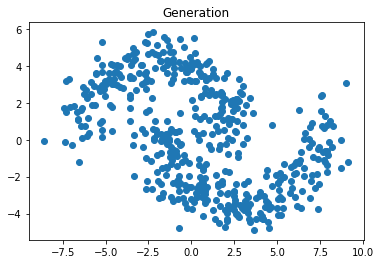

Epoch: 4400 loss: 4870.7949 recon_loss: 1722.3374 kl_loss: 3148.4575 avg mean: 0.0028 avg std: 0.9548, time: 12.7198


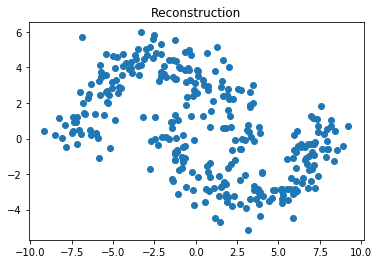

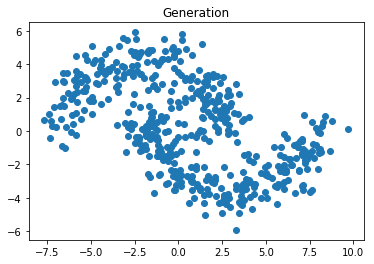

Epoch: 4600 loss: 4869.4798 recon_loss: 1733.3695 kl_loss: 3136.1103 avg mean: -0.0251 avg std: 0.9572, time: 12.5961


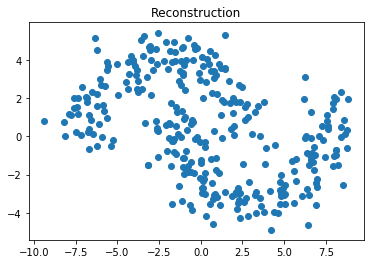

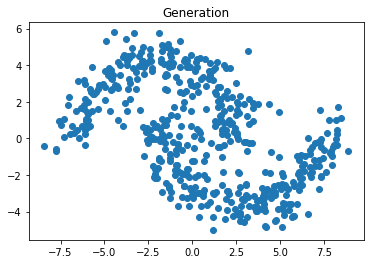

Epoch: 4800 loss: 4861.9591 recon_loss: 1714.2967 kl_loss: 3147.6624 avg mean: 0.0253 avg std: 0.9480, time: 12.8332


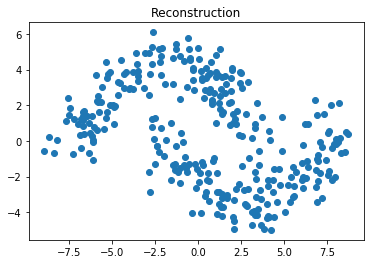

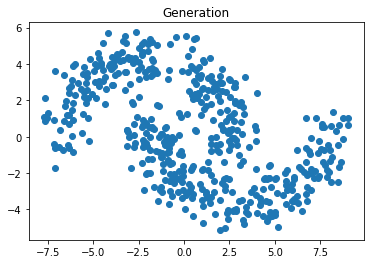

Epoch: 5000 loss: 4877.5158 recon_loss: 1719.7887 kl_loss: 3157.7271 avg mean: -0.0389 avg std: 0.9512, time: 12.9558


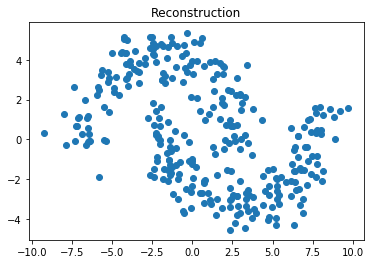

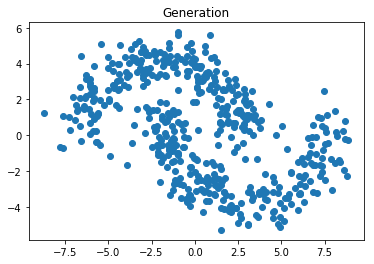

Epoch: 5200 loss: 4885.9035 recon_loss: 1728.9744 kl_loss: 3156.9291 avg mean: 0.0668 avg std: 0.9327, time: 12.9208


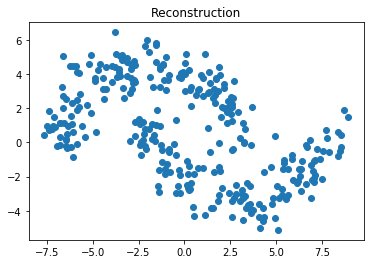

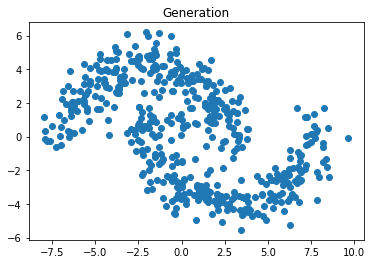

Epoch: 5400 loss: 4863.5049 recon_loss: 1690.1172 kl_loss: 3173.3877 avg mean: -0.0513 avg std: 0.9613, time: 12.9041


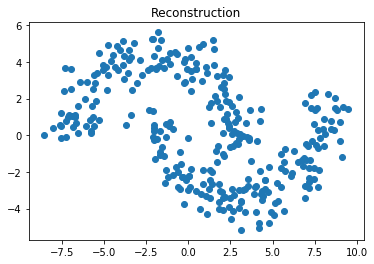

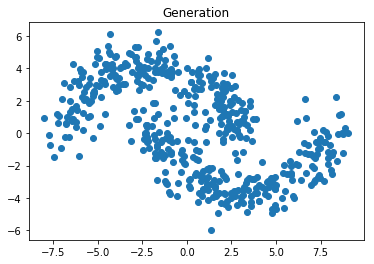

Epoch: 5600 loss: 4865.4348 recon_loss: 1701.6140 kl_loss: 3163.8208 avg mean: 0.1157 avg std: 0.9569, time: 12.8565


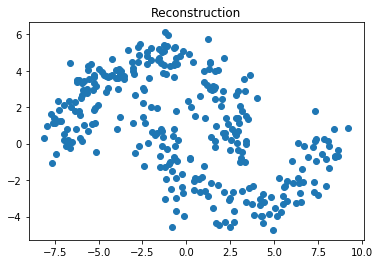

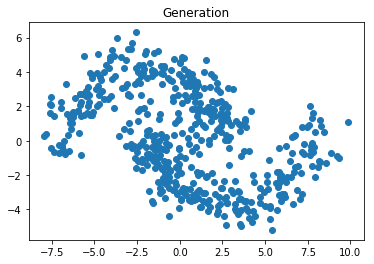

Epoch: 5800 loss: 4865.6707 recon_loss: 1705.8058 kl_loss: 3159.8648 avg mean: 0.0800 avg std: 0.9677, time: 12.8112


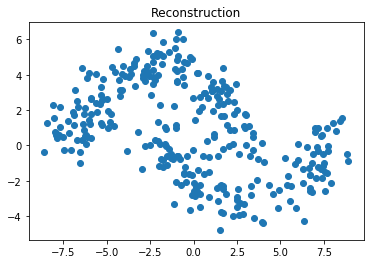

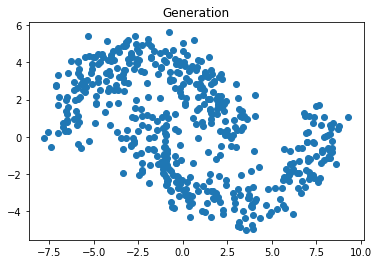

Epoch: 6000 loss: 4854.1223 recon_loss: 1703.1976 kl_loss: 3150.9247 avg mean: -0.0057 avg std: 0.9764, time: 12.8134


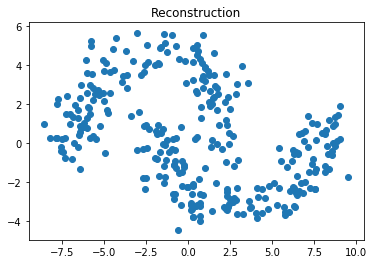

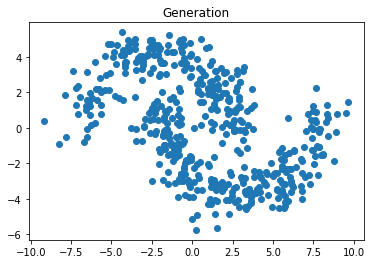

Epoch: 6200 loss: 4863.4817 recon_loss: 1705.2049 kl_loss: 3158.2768 avg mean: -0.0059 avg std: 0.9336, time: 12.8315


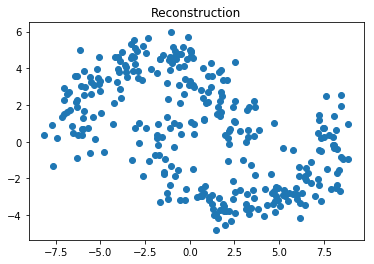

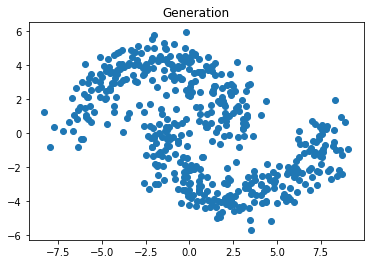

Epoch: 6400 loss: 4868.9364 recon_loss: 1722.2226 kl_loss: 3146.7138 avg mean: -0.0217 avg std: 0.9423, time: 12.8151


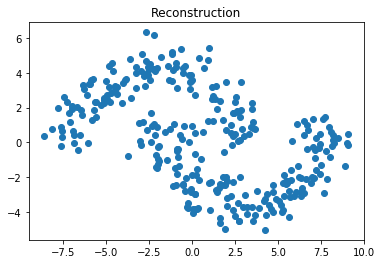

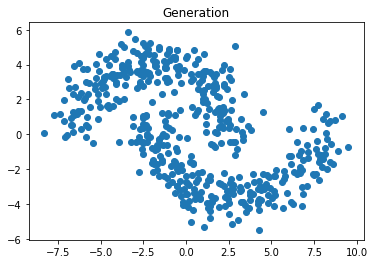

Epoch: 6600 loss: 4866.3401 recon_loss: 1713.8358 kl_loss: 3152.5042 avg mean: 0.0073 avg std: 0.9561, time: 12.7927


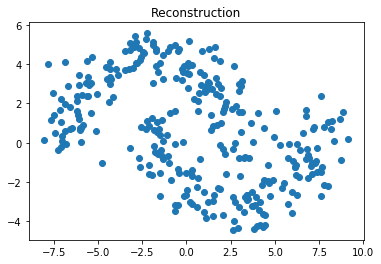

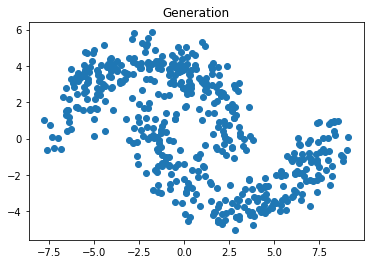

Epoch: 6800 loss: 4878.6377 recon_loss: 1712.4847 kl_loss: 3166.1530 avg mean: -0.0053 avg std: 0.9361, time: 12.7752


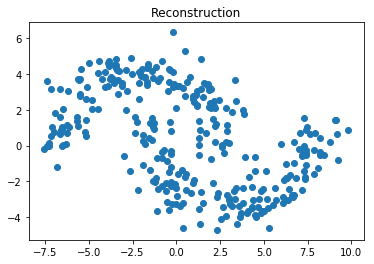

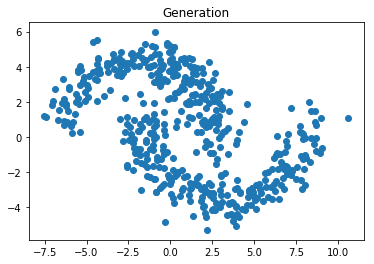

Epoch: 7000 loss: 4884.2786 recon_loss: 1738.9889 kl_loss: 3145.2897 avg mean: 0.0669 avg std: 0.9664, time: 12.9180


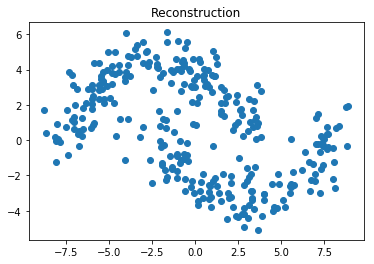

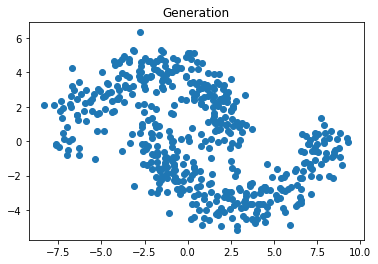

Epoch: 7200 loss: 4862.5894 recon_loss: 1687.0498 kl_loss: 3175.5396 avg mean: -0.0387 avg std: 0.9426, time: 12.8528


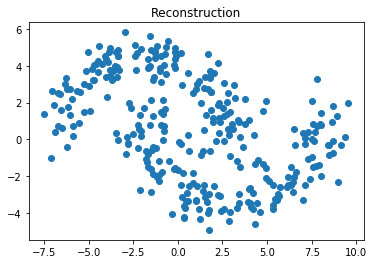

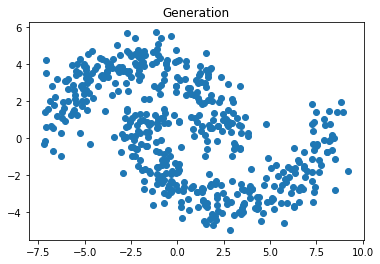

Epoch: 7400 loss: 4846.7329 recon_loss: 1679.4836 kl_loss: 3167.2492 avg mean: 0.0262 avg std: 0.9507, time: 12.8482


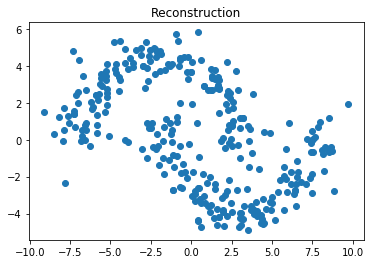

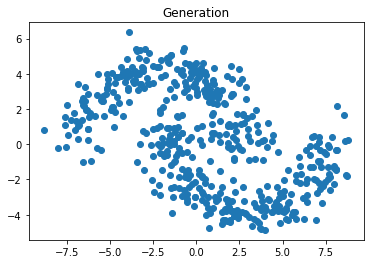

In [67]:
# Please note: the model should converge faster!
t=time.time()
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)
        #print(x.shape)
        #print(x_mu.shape)
        #print(x_log_var.shape)
        #print(z_mu.shape)
        #print(z_log_var.shape)
        
        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 200 == 0:
        print(
            "Epoch: {} loss: {:.4f} recon_loss: {:.4f} kl_loss: {:.4f} avg mean: {:.4f} avg std: {:.4f}, time: {:.4f}".format(
            i,(recon_loss_acc + kl_acc) / len(moons), recon_loss_acc / len(moons),
                kl_acc / len(moons), z_mu.detach().mean(),torch.exp(z_log_var.detach() / 2).mean(),
                time.time()-t
            )
        )
        t=time.time()
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

In [68]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

(-5, 5)

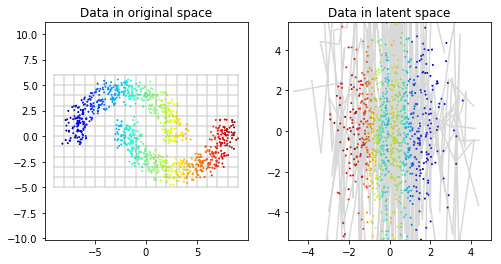

In [69]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")

vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_grid = vae.encode(torch.Tensor(grid).to(device))[0].cpu().detach().numpy()
enc_data = vae.encode(torch.Tensor(data).to(device))[0].cpu().detach().numpy()


plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")
plt.ylim((-5,5))
plt.xlim((-5,5))

Text(0.5,1,'Generated data in original space')

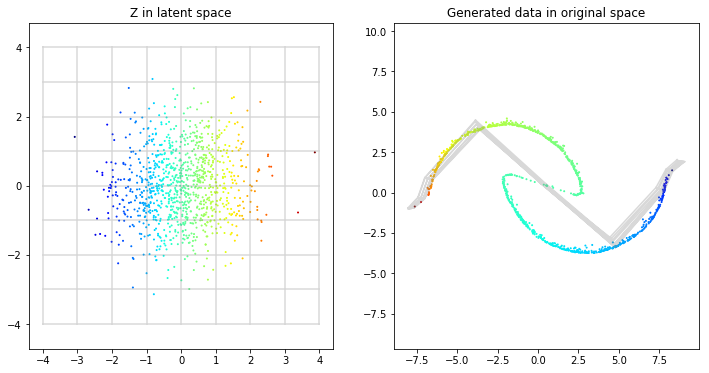

In [70]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = vae.decode(latent_samples.to(device))[0].cpu().detach().numpy()
grid_gen = vae.decode(torch.Tensor(latent_grid).to(device))[0].cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## GAN

In [71]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

In [73]:
def generator_loss(DG, eps=1e-6):
    # Define Generator loss. Use eps for numerical stability of log.
    return - torch.sum(torch.log(DG+eps))/2


def discriminator_loss(DG,DR, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    return -torch.sum((torch.log(DG+eps)+torch.log(1-DR+eps)))/2


In [76]:
z_dim = 2
hid_dim = 64
lr = 0.0001

G = Generator(in_dim=z_dim, hid_dim=hid_dim).to(device)
D = Discriminator(hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

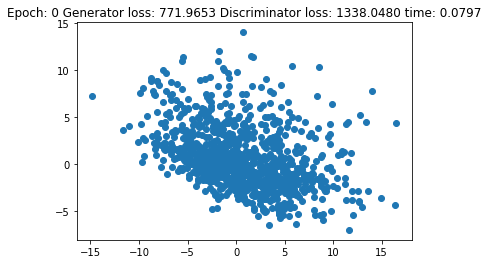

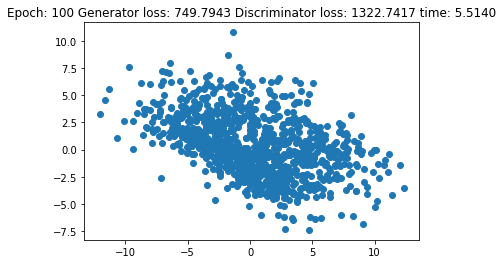

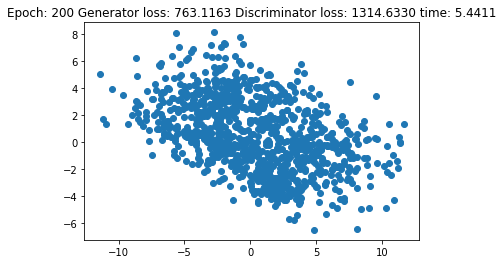

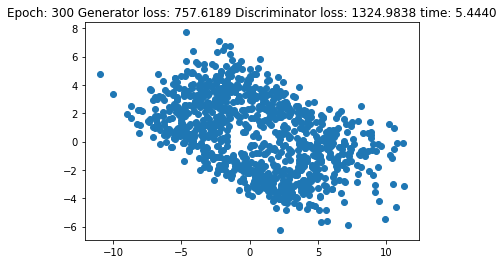

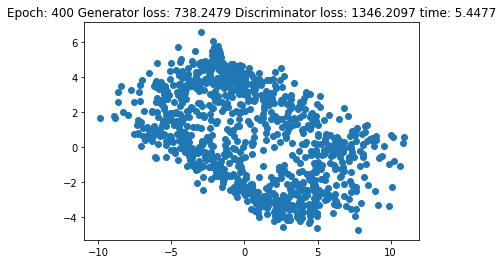

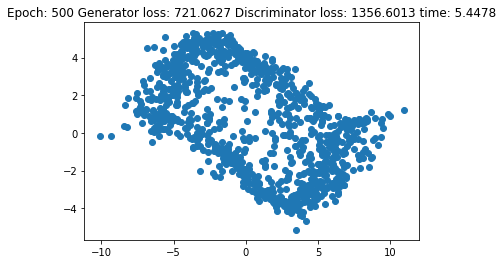

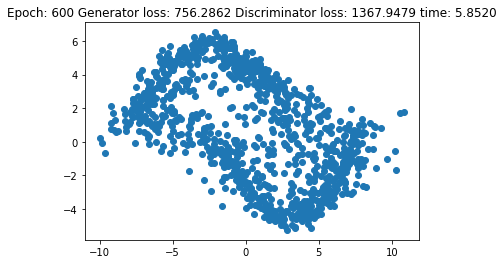

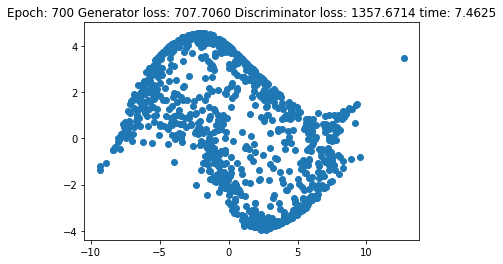

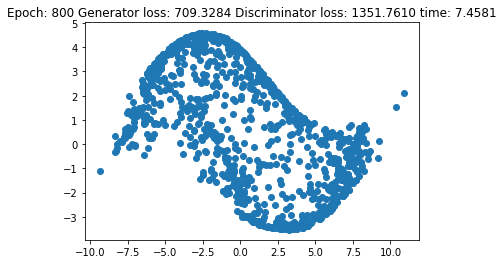

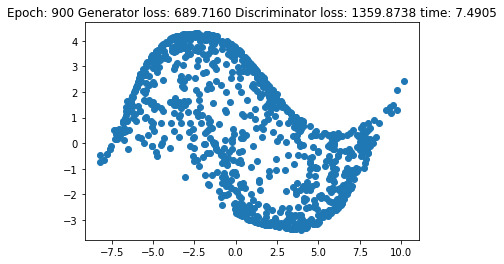

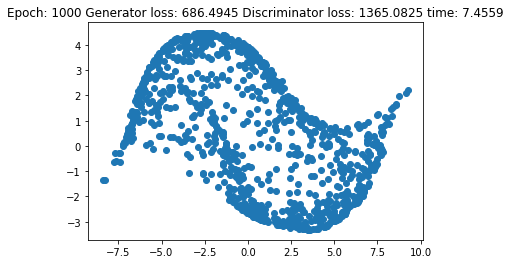

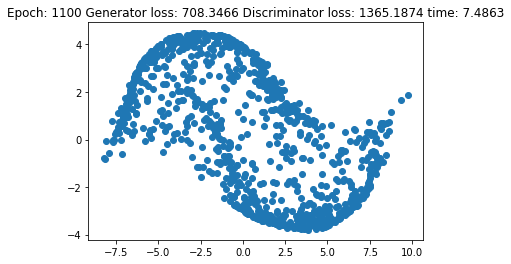

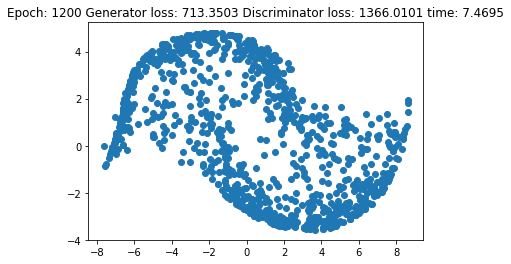

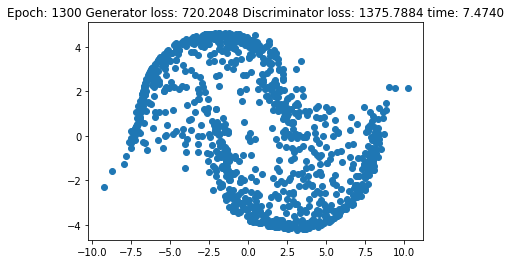

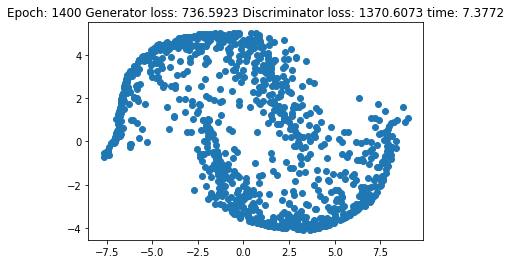

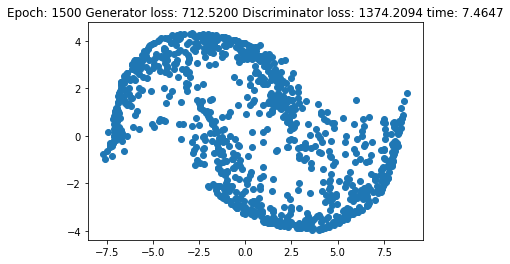

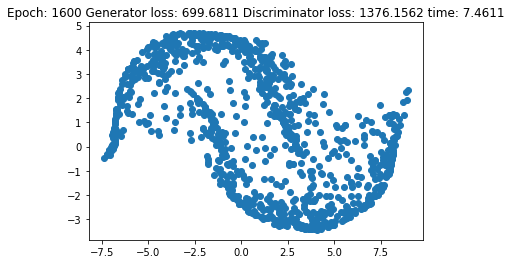

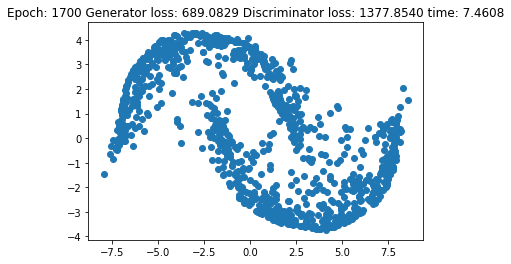

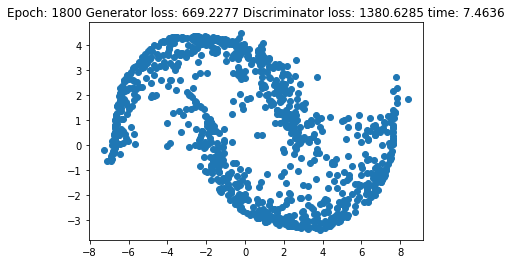

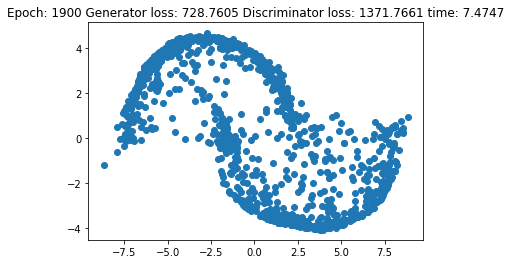

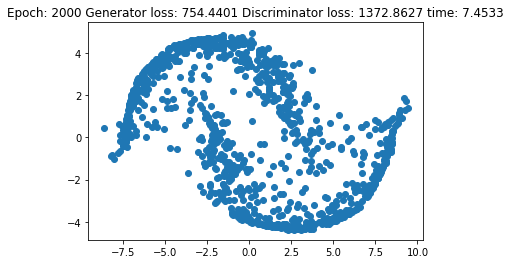

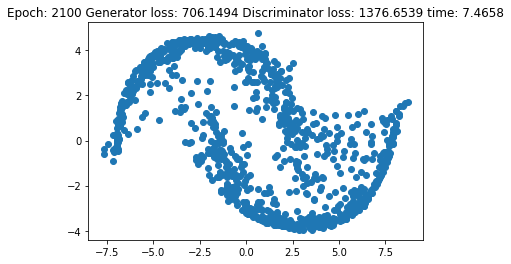

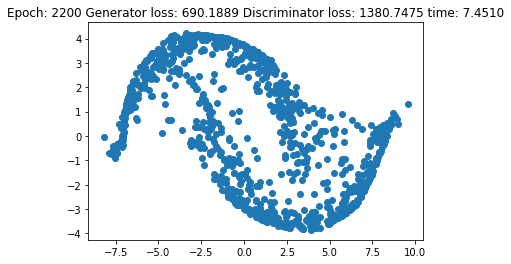

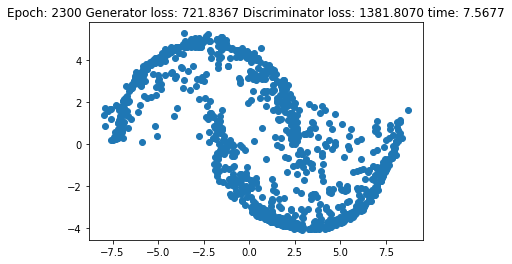

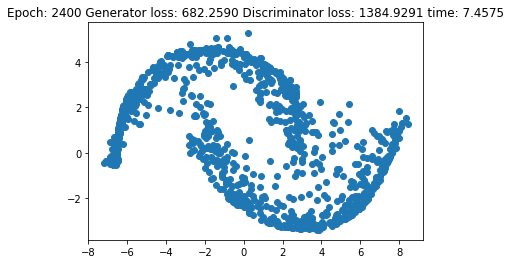

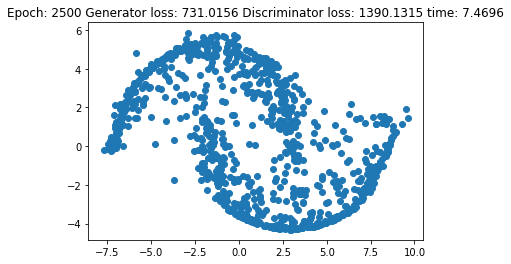

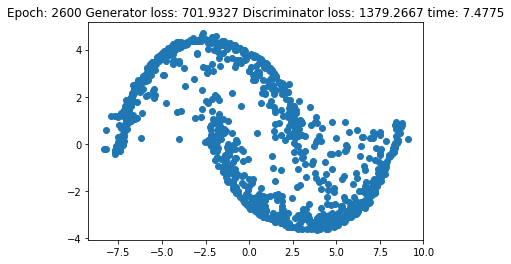

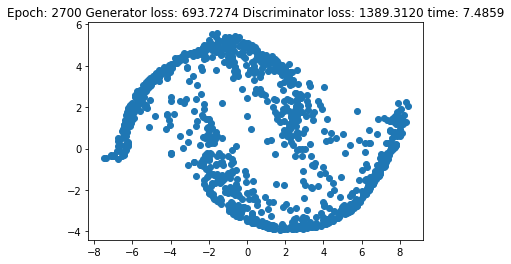

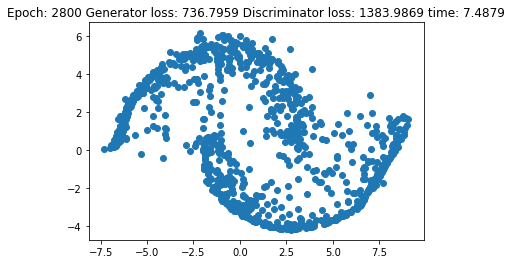

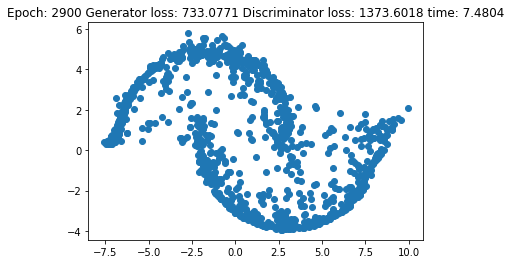

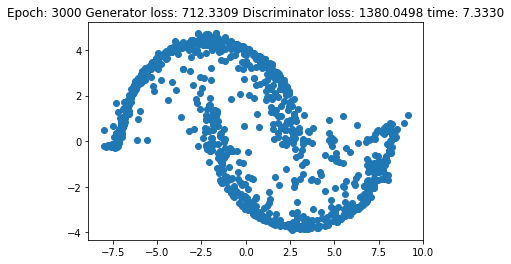

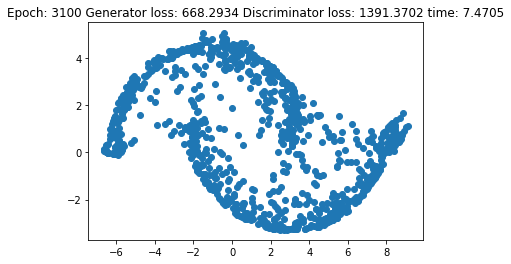

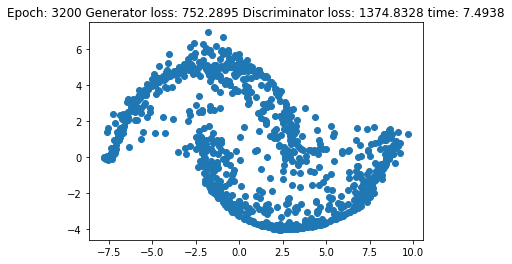

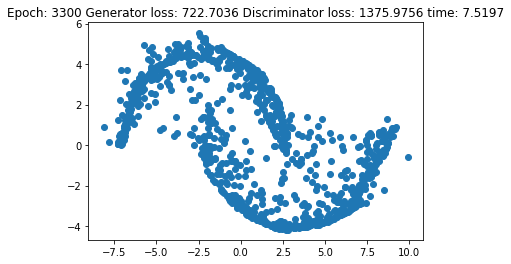

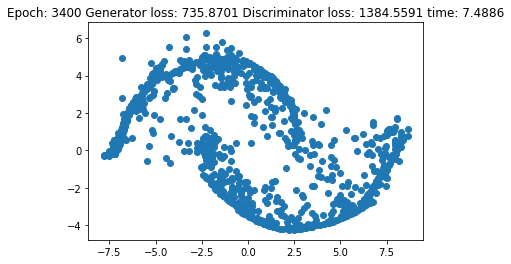

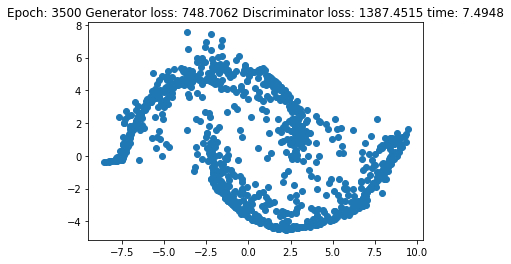

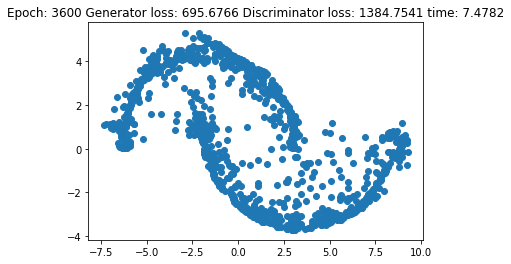

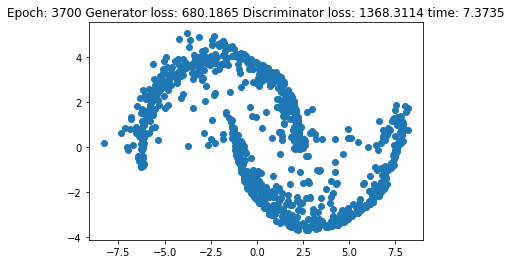

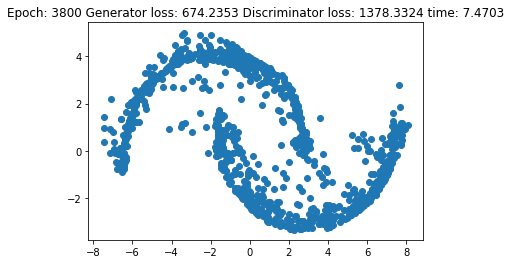

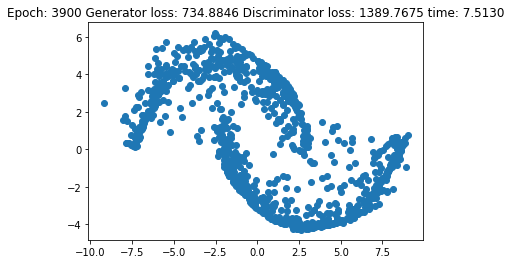

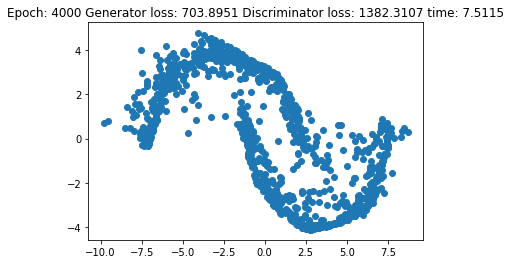

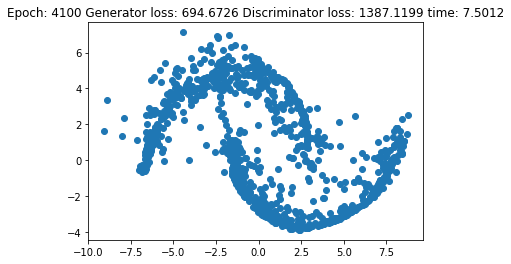

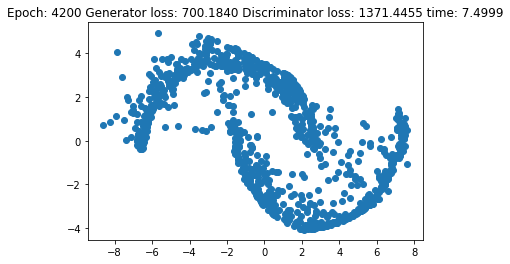

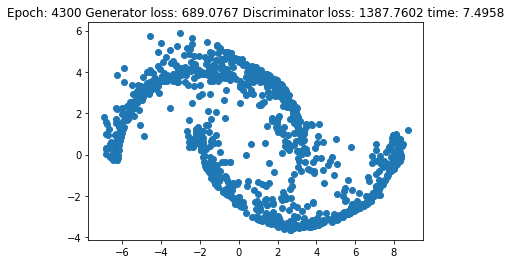

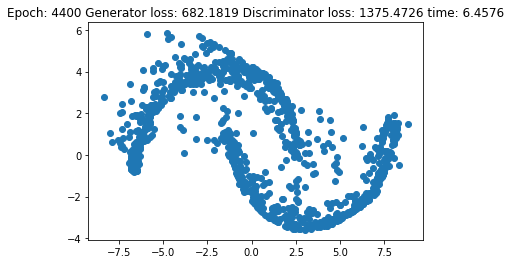

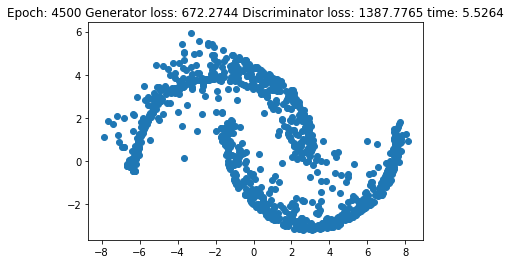

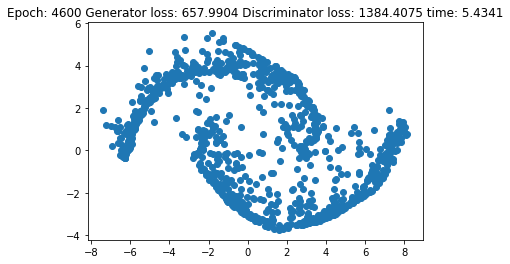

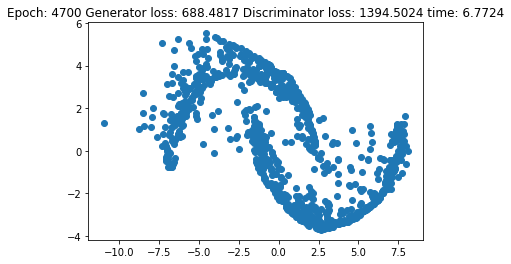

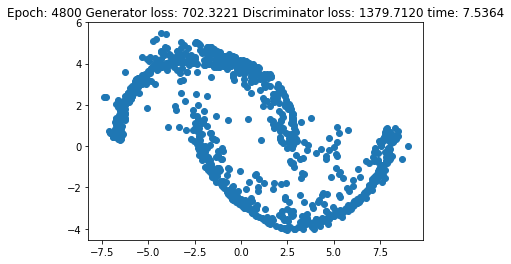

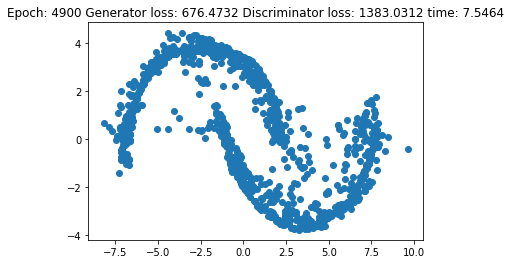

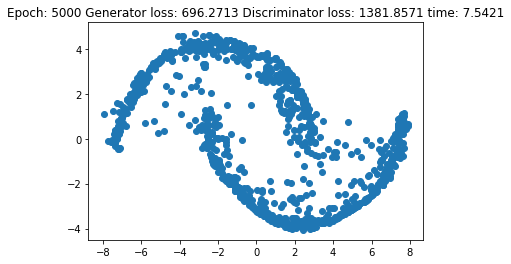

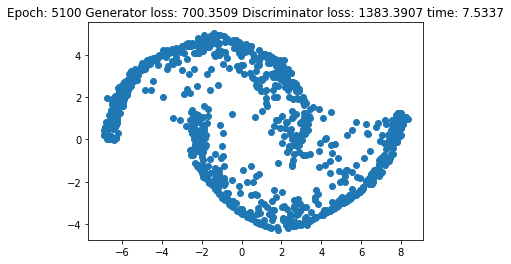

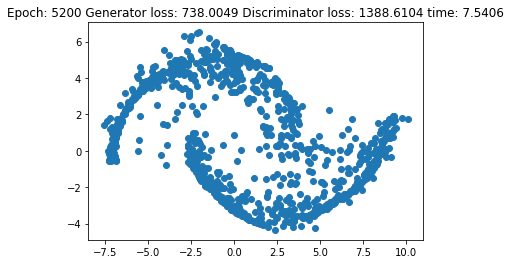

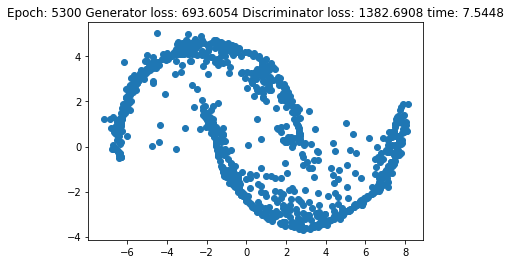

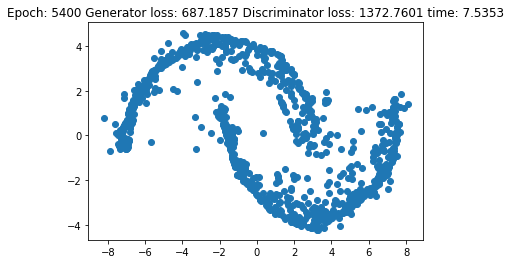

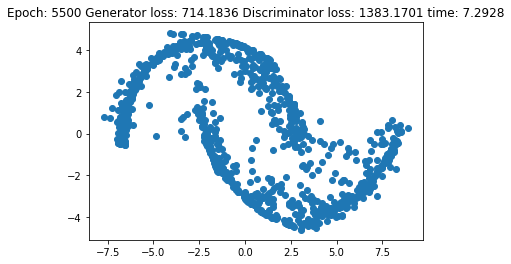

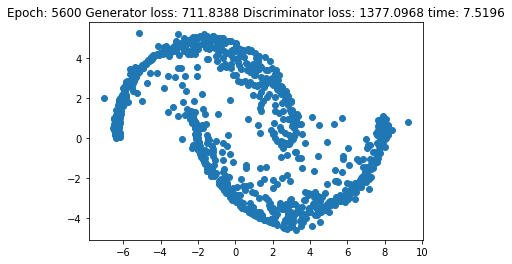

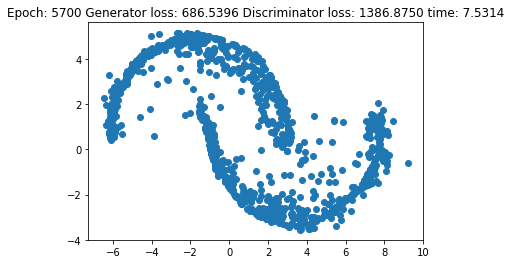

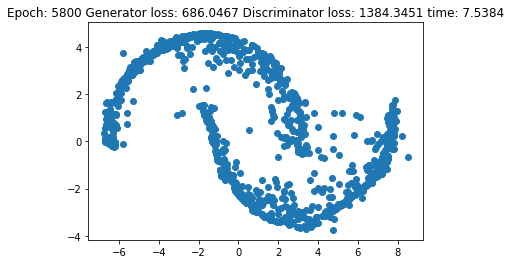

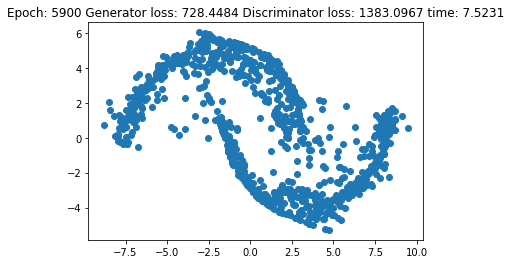

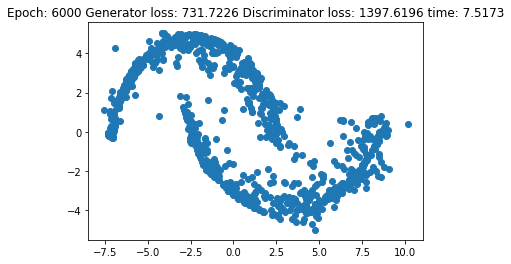

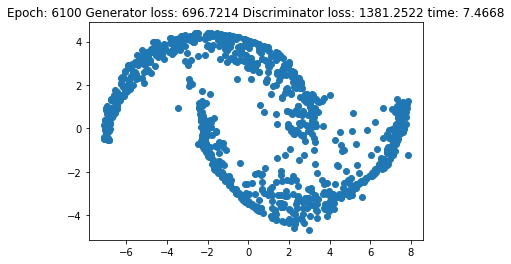

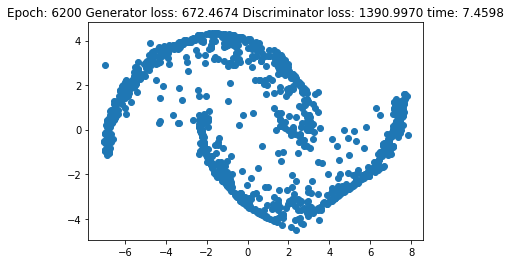

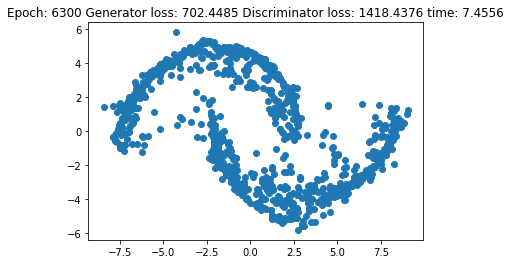

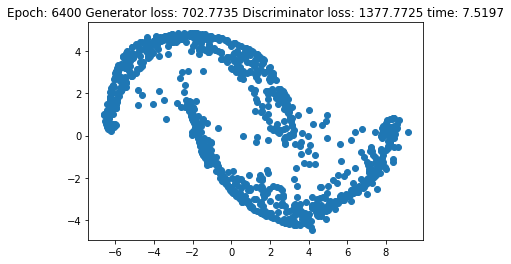

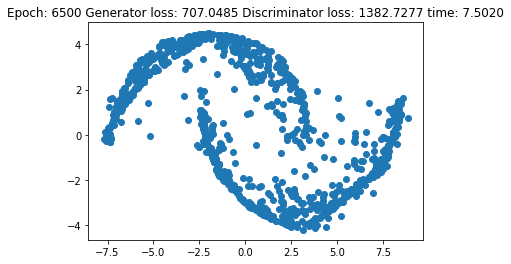

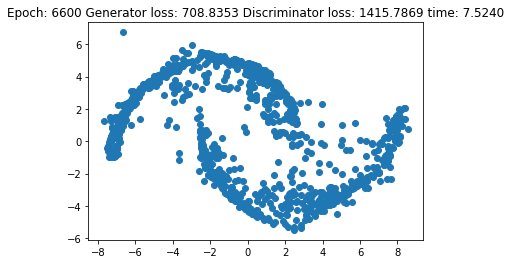

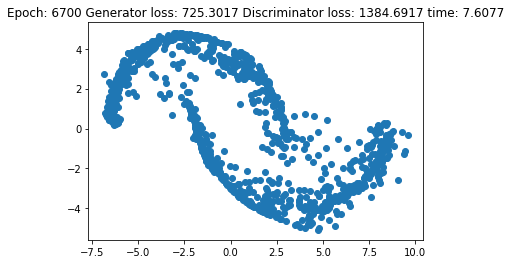

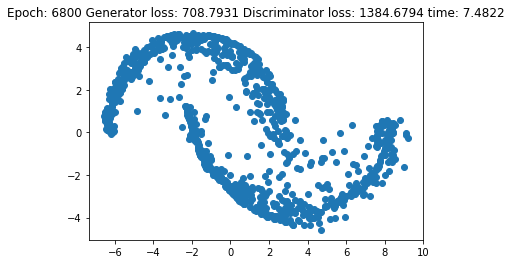

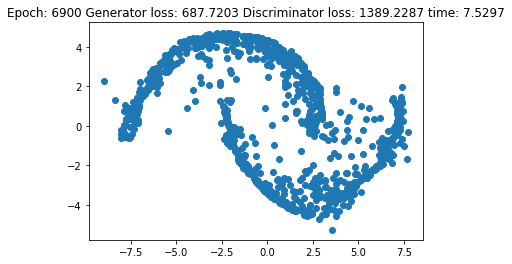

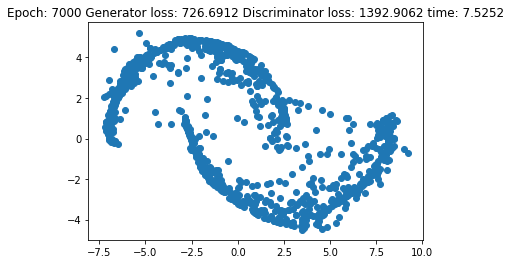

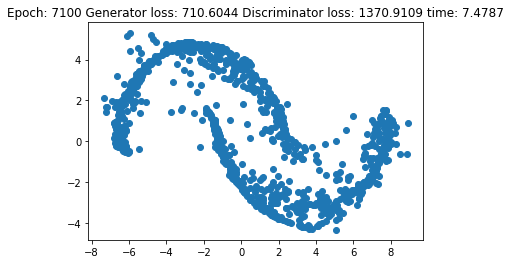

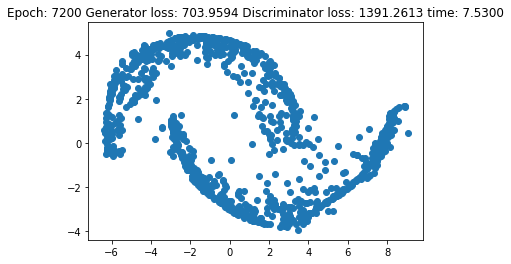

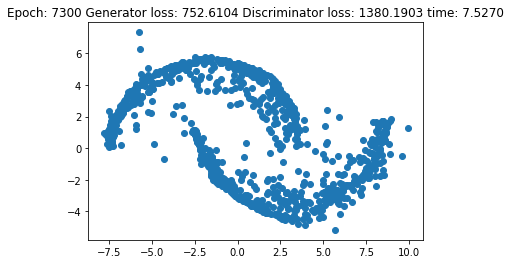

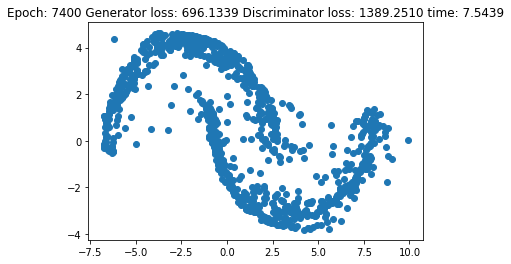

In [78]:
t=time.time()
for i in range(7500):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x, in moons_dl:
        x = x.float().to(device)

        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G(z)  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss= discriminator_loss(D(x_fake_detached),D(x))

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 100 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title(
                "Epoch: {} Generator loss: {:.4f} Discriminator loss: {:.4f} time: {:.4f}".format(
                i, G_loss_acc / len(moons), D_loss_acc / len(moons), time.time()-t
                )
            )
            t=time.time()
            plt.show()

Text(0.5,1,'Generated data in original space')

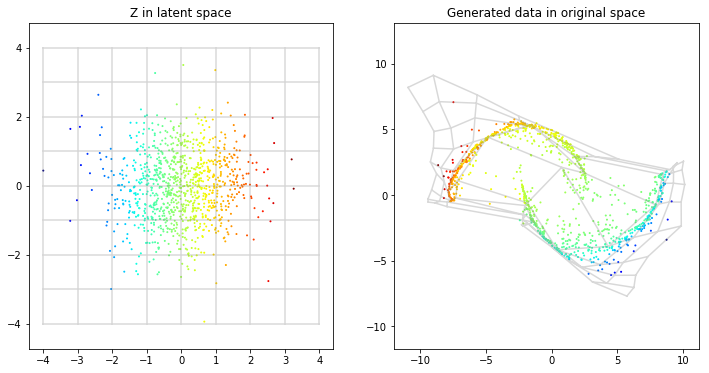

In [82]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

G.eval()
# TODO: compute the projection into data space of the latent saples and the grid
x_gen = G(torch.Tensor(latent_samples).to(device)).detach().cpu().numpy()
grid_gen = G(torch.Tensor(latent_grid).to(device)).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## Normalizing Flow

In [4]:
class CouplingLayer(nn.Module):
    def __init__(self, idx, in_dim, hid_dim, out_dim):
        super(CouplingLayer, self).__init__()
        self.in_dim = in_dim // 2
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2
        self.odd = idx % 2 == 1

        self.s = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ):
        # Split x into two halves along dimension axis.
        x1, x2 = x[:, 0, None], x[:, 1, None]  # x1, x2 = TODO
        if self.odd:
            x1, x2 = x2, x1

        s = self.s(x1)
        t = self.t(x1)
        # Transform x2 using s and t.
        # x1 = x1
        x2 = x2*s+t

        if self.odd:
            x1, x2 = x2, x1

        # Add log determinant of the Jacobian
        ldetJ += torch.log(torch.abs(s))*self.out_dim

        return torch.cat([x1, x2], dim=1), ldetJ

    def invert(self, z):
        z1, z2 = z[:, 0, None], z[:, 1, None]
        if self.odd:
            z1, z2 = z2, z1

        s = self.s(z1)
        t = self.t(z1)
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = (z2-t)/s

        if self.odd:
            z1, z2 = z2, z1

        return torch.cat([z1, z2], dim=1)


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ)
        return x, ldetJ

    def invert(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.invert(z)
        return z

In [5]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return -torch.sum(prior_z.log_prob(z)+ldetJ)


In [226]:
n_coupling_layers = 6
hid_dim = 64
lr = 0.003

flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim).to(device)
optimizer = optim.Adam(flow.parameters(), lr=lr)
prior_z = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

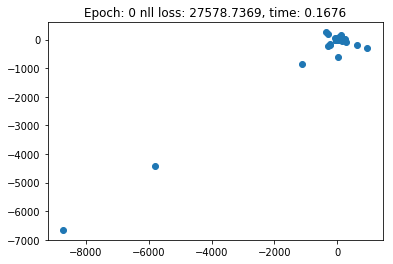

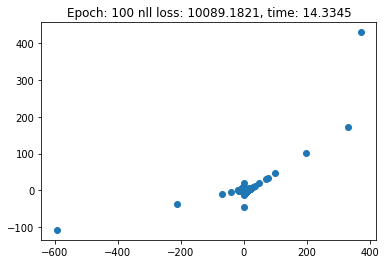

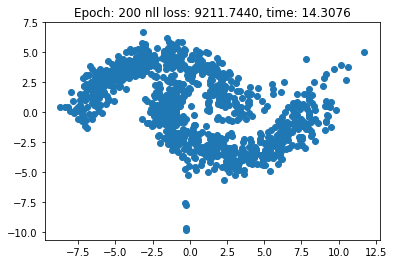

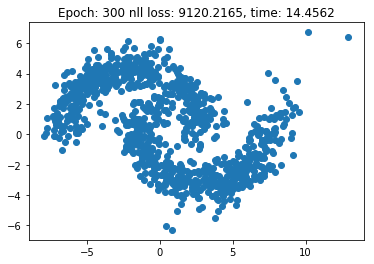

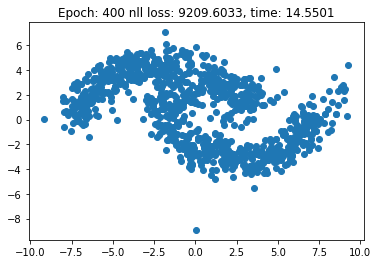

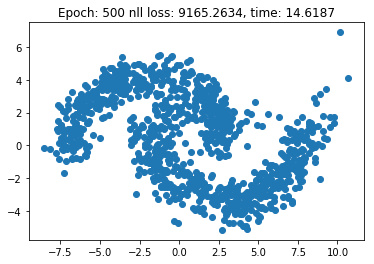

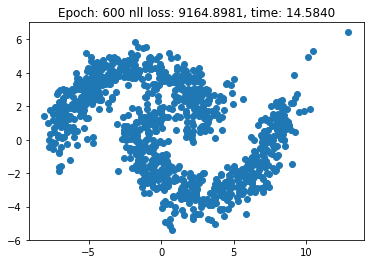

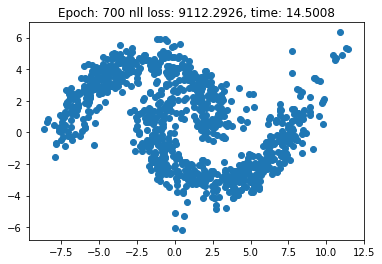

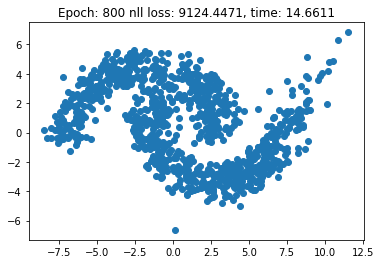

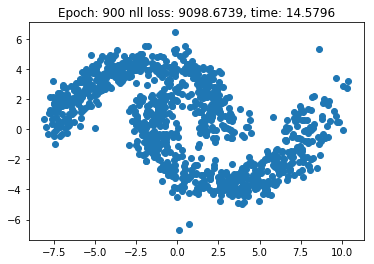

In [234]:
t=time.time()
for i in range(1000):
    loss_acc = 0.0
    flow.train()
    for x, in moons_dl:
        x = x.float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 1e2
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)
        #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if i % 100 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plt.scatter(x[:, 0], x[:, 1])
            plt.title("Epoch: {} nll loss: {:.4f}, time: {:.4f}".format(
            i,loss_acc / len(moons) ,time.time()-t))
            t=time.time()
            plt.show()

(-5, 5)

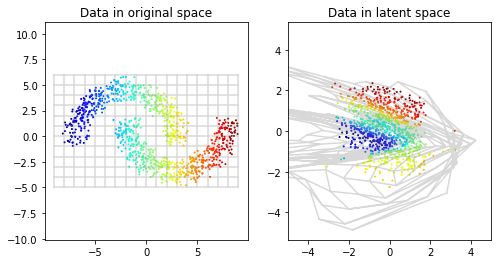

In [235]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")


plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_grid = flow(torch.Tensor(grid).to(device))[0].detach().cpu().numpy()
enc_data = flow(torch.Tensor(data).to(device))[0].detach().cpu().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

Text(0.5,1,'Generated data in original space')

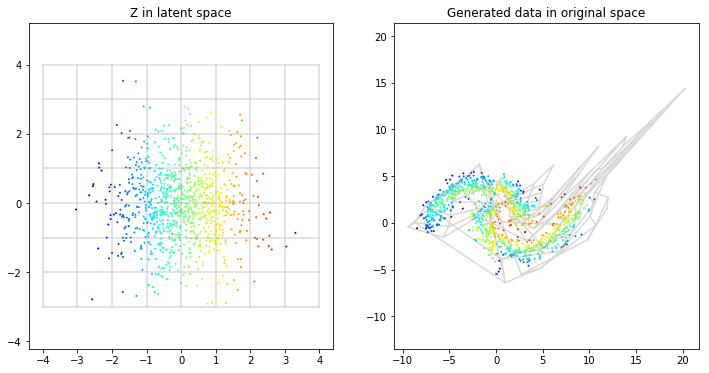

In [236]:
latent_samples = prior_z.sample((1000,)).cpu()

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = flow.invert(torch.Tensor(latent_samples).to(device)).detach().cpu().numpy()
grid_gen = flow.invert(torch.Tensor(latent_grid).to(device)).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

In [12]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return -torch.sum(prior_z.log_prob(z)+ldetJ.reshape(-1))


In [199]:
device="cpu"

In [326]:
n_coupling_layers = 6
hid_dim = 64
lr = 0.003

flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim).to(device)
optimizer = optim.Adam(flow.parameters(), lr=lr, betas=(0.75,0.95))
prior_z = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

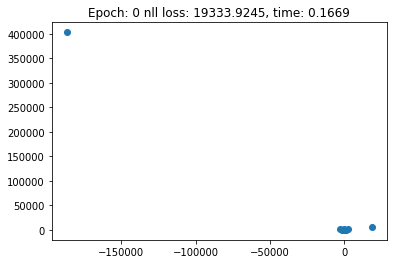

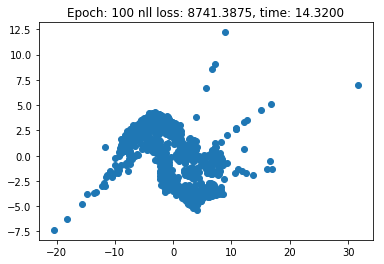

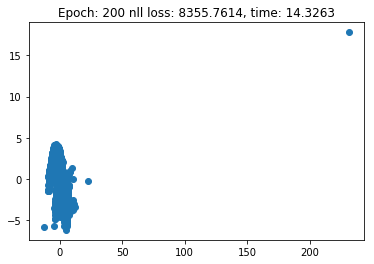

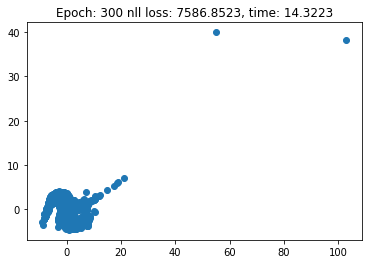

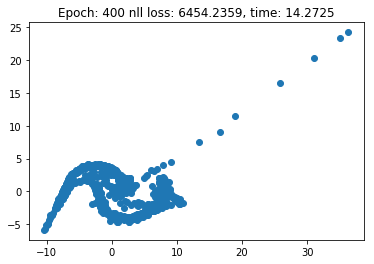

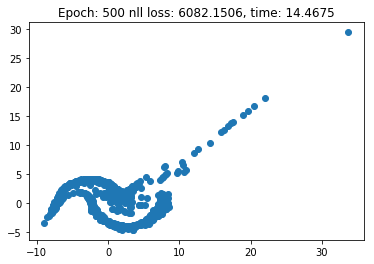

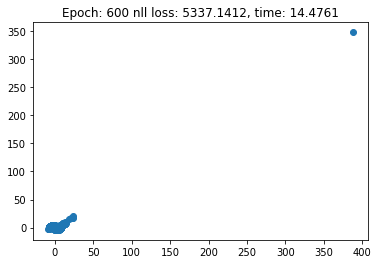

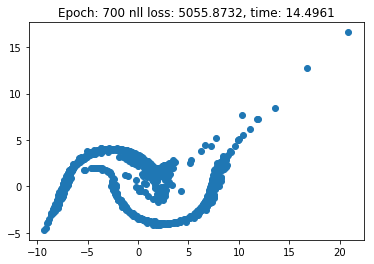

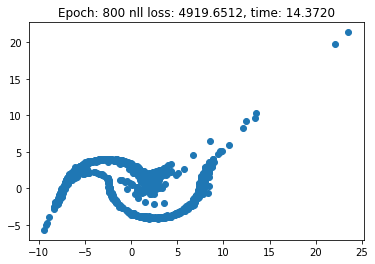

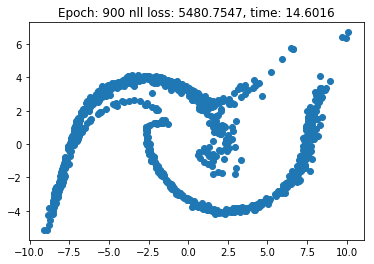

In [239]:
t=time.time()
flow.train()
for i in range(1000):
    loss_acc = 0.0
    for x, in moons_dl:
        x = x.float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 1e2
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)
        #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if i % 100 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plt.scatter(x[:, 0], x[:, 1])
            plt.title("Epoch: {} nll loss: {:.4f}, time: {:.4f}".format(
            i,loss_acc / len(moons) ,time.time()-t))
            t=time.time()
            plt.show()
        flow.train()

(-5, 5)

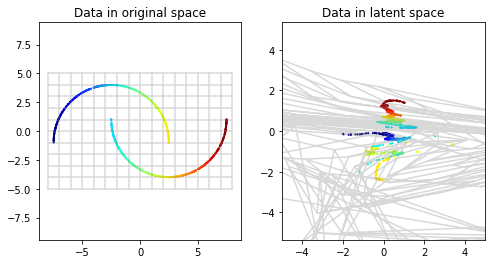

In [240]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")


plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_grid = flow(torch.Tensor(grid).to(device))[0].detach().cpu().numpy()
enc_data = flow(torch.Tensor(data).to(device))[0].detach().cpu().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

Text(0.5,1,'Generated data in original space')

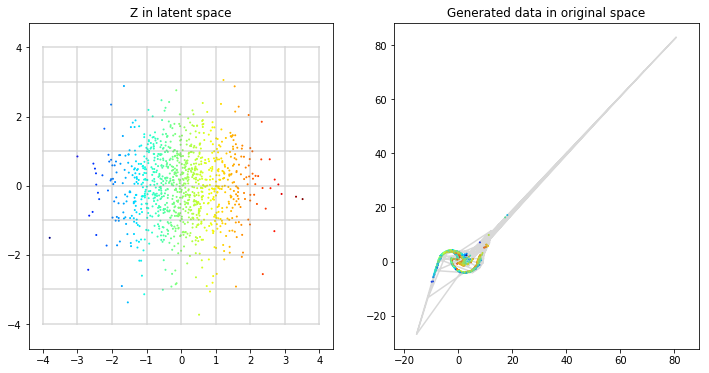

In [241]:
latent_samples = prior_z.sample((1000,)).cpu()

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = flow.invert(torch.Tensor(latent_samples).to(device)).detach().cpu().numpy()
grid_gen = flow.invert(torch.Tensor(latent_grid).to(device)).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## MNIST

In [4]:
import torchvision
from tqdm import tqdm

In [5]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
        transformations=None,
        multiplicationOfSet=1
    ):
        """A torch dataloader that fetches data from memory."""
        batches=[]
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            for j in range(multiplicationOfSet):
                if transformations is not None:
                    batchTrans=transformations(batch[0])
                    batches.append([batchTrans,batch[1]])
                else:
                    batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.transformations=transformations

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [6]:
# Monkey-patch MNIST to use a more robust MIST mirror
torchvision.datasets.MNIST.resources = [
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]

In [7]:
def plotNumbersFromTensor(T, liczbaRysowanych=64):
    P=T[:liczbaRysowanych,:].reshape((-1,28,28)).cpu().detach().numpy()
    plt.gcf().set_size_inches((12,5))
    for i in range(liczbaRysowanych):
        plt.subplot(4,16,i+1)
        plt.axis("off")
        plt.imshow(P[i,:,:],cmap="gray")

# Wejście 0-1

In [8]:
# Load the data

batch_size = 2048
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]
mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

100%|██████████| 10000/10000 [00:01<00:00, 7027.47it/s]


# Poprawiony model bez exp

In [13]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return -torch.sum(prior_z.log_prob(z)+ldetJ)

In [10]:
n_coupling_layers = 30
hid_dim = 512
in_dim=28**2


flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim, in_dim=in_dim, out_dim=in_dim).to(device)
prior_z = MultivariateNormal(torch.zeros(in_dim).to(device), torch.eye(in_dim).to(device))

In [11]:
lr = 0.001
optimizer = optim.Adam(flow.parameters(), lr=lr, betas=(0.75,0.9))

In [ ]:
t=time.time()
flow.train()
iteracja=0
for i in range(1000):
    loss_acc = 0.0
    for x,_ in mnist_loaders["train"]:
        iteracja+=1
        x = nn.Flatten()(x).float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 255
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if iteracja % 1 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plotNumbersFromTensor(x)
            plt.suptitle("Epoch: {} nll loss: {:.4f}, time: {:.4f}".format(
            i,loss_acc / len(mnist_loaders["train"]) ,time.time()-t))
            t=time.time()
            plt.show()
        flow.train()

In [15]:
torch.save(flow.state_dict(), "MNIST-0-1-poprawionyWyznacznikBezExp.pth".format(str(time.time())))

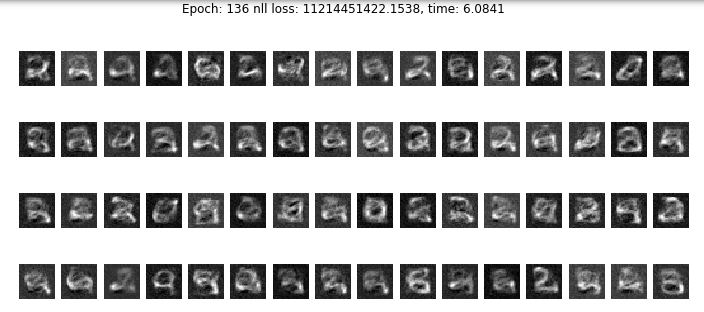

# Uczenie z exp(s)

In [158]:
class CouplingLayer(nn.Module):
    def __init__(self, idx, in_dim, hid_dim, out_dim):
        super(CouplingLayer, self).__init__()
        self.in_dim = in_dim // 2
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2
        self.odd = idx % 2 == 1

        self.s = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ):
        # Split x into two halves along dimension axis.
        x1, x2 = x[:, :x.shape[1]//2], x[:, x.shape[1]//2:]  # x1, x2 = TODO
        if self.odd:
            x1, x2 = x2, x1

        #print(self.in_dim, self.hid_dim, self.out_dim)
        #print(x1.shape, x2.shape)
        #print(x.shape)
        s = self.s(x1)
        t = self.t(x1)
        # Transform x2 using s and t.
        # x1 = x1
        x2 = x2*torch.exp(s)+t

        if self.odd:
            x1, x2 = x2, x1

        # Add log determinant of the Jacobian
        ldetJ += s.sum(1)

        return torch.cat([x1, x2], dim=1), ldetJ

    def invert(self, z):
        z1, z2 = z[:, :x.shape[1]//2], z[:, x.shape[1]//2:]
        print(z.shape, z1.shape, z2.shape)
        if self.odd:
            z1, z2 = z2, z1

        s = self.s(z1)
        t = self.t(z1)
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = (z2-t)/torch.exp(s)

        if self.odd:
            z1, z2 = z2, z1

        return torch.cat([z1, z2], dim=1)


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ)
        return x, ldetJ

    def invert(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.invert(z)
        return z

In [17]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return -torch.sum(prior_z.log_prob(z)+ldetJ)

In [18]:
n_coupling_layers = 30
hid_dim = 512
in_dim=28**2


flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim, in_dim=in_dim, out_dim=in_dim).to(device)
prior_z = MultivariateNormal(torch.zeros(in_dim).to(device), torch.eye(in_dim).to(device))

In [16]:
lr = 0.001
optimizer = optim.Adam(flow.parameters(), lr=lr, betas=(0.75,0.9))

In [ ]:
t=time.time()
flow.train()
iteracja=0
for i in range(1000):
    loss_acc = 0.0
    for x,_ in mnist_loaders["train"]:
        iteracja+=1
        x = nn.Flatten()(x).float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 255
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)
        #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if iteracja % 1 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plotNumbersFromTensor(x)
            plt.suptitle("Epoch: {} nll loss: {:.4f}, time: {:.4f}".format(
            i,loss_acc / len(mnist_loaders["train"]) ,time.time()-t))
            t=time.time()
            plt.show()
        flow.train()

In [18]:
torch.save(flow.state_dict(), "MNIST-0-1-dobryModelzExp.pth".format(str(time.time())))

In [20]:
flow.load_state_dict(torch.load("MNIST-0-1-dobryModelzExp.pth"))

<All keys matched successfully>

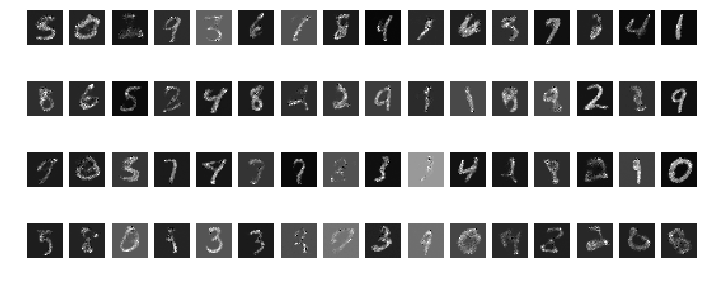

In [22]:
flow.eval()
with torch.no_grad():
    z = prior_z.sample((1000,))
    x = flow.invert(z).cpu()
    plotNumbersFromTensor(x)
    #plt.suptitle("Epoch: {} nll loss: {:.4f}, time: {:.4f}".format(
    #i,loss_acc / len(mnist_loaders["train"]) ,time.time()-t))
    t=time.time()
    plt.show()

# Interpolacja między punktami

In [52]:
S=16
L=torch.linspace(0,1,S).reshape((S,1))

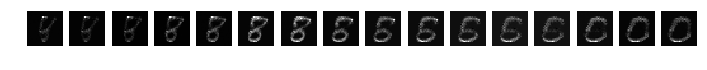

In [59]:
a1=prior_z.sample([1]).to("cpu")
a2=prior_z.sample([1]).to("cpu")

I=L@a1+(1-L)@a2

x = flow.invert(I.to("cuda")).cpu()
plotNumbersFromTensor(x, liczbaRysowanych=16)

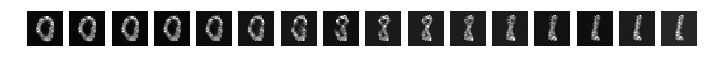

In [60]:
a1=prior_z.sample([1]).to("cpu")
a2=prior_z.sample([1]).to("cpu")

I=L@a1+(1-L)@a2

x = flow.invert(I.to("cuda")).cpu()
plotNumbersFromTensor(x, liczbaRysowanych=16)

# Interpolacja po sferze

In [150]:
def generujInterpolacjeZeStalymPromieniem():

    a1=prior_z.sample([1]).to("cpu")
    delta=(torch.rand(a1.shape)-0.5)*0.01

    normaA1=torch.sum(a1**2)

    punkty=[a1]
    for i in range(15):
        aNext=punkty[-1]+delta
        aNext[0,-1]=torch.sqrt(normaA1-torch.sum(aNext[0,:-1]**2))
        punkty.append(torch.Tensor(aNext.detach().numpy().copy()))

    T=torch.cat(punkty,0)

    x = flow.invert(T.to("cuda")).cpu()
    plotNumbersFromTensor(x, liczbaRysowanych=16)

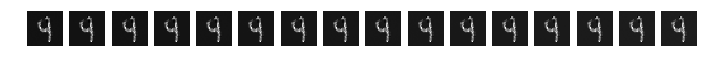

In [152]:
generujInterpolacjeZeStalymPromieniem()

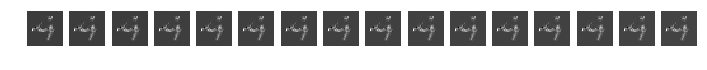

In [154]:
generujInterpolacjeZeStalymPromieniem()

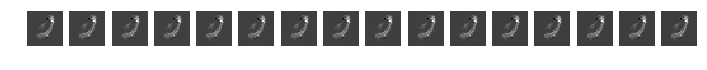

In [155]:
generujInterpolacjeZeStalymPromieniem()

# Conditional normalized flow

In [9]:
class CouplingLayer(nn.Module):
    def __init__(self, idx, in_dim, hid_dim, out_dim):
        super(CouplingLayer, self).__init__()
        self.in_dim = in_dim // 2 + 10
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2
        self.odd = idx % 2 == 1

        self.s = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ):
        # Split x into two halves along dimension axis.
        x1, x2, labels = x[:, :(x.shape[1]-10)//2], x[:, (x.shape[1]-10)//2:-10], x[:, -10:]
        if self.odd:
            x1, x2 = x2, x1

        #print(self.in_dim, self.hid_dim, self.out_dim)
        #print(x1.shape, x2.shape)
        #print(x.shape)
        s = self.s(torch.cat([x1, labels], dim=1))
        t = self.t(torch.cat([x1, labels], dim=1))
        # Transform x2 using s and t.
        # x1 = x1
        x2 = x2*torch.exp(s)+t

        if self.odd:
            x1, x2 = x2, x1

        # Add log determinant of the Jacobian
        ldetJ += s.sum(1)

        return torch.cat([x1, x2, labels], dim=1), ldetJ

    def invert(self, z):
        z1, z2, labels = z[:, :(z.shape[1]-10)//2], z[:, (z.shape[1]-10)//2:-10], z[:, -10:]
        if self.odd:
            z1, z2 = z2, z1

        s = self.s(torch.cat([z1, labels], dim=1))
        t = self.t(torch.cat([z1, labels], dim=1))
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = (z2-t)/torch.exp(s)

        if self.odd:
            z1, z2 = z2, z1

        return torch.cat([z1, z2, labels], dim=1)


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ)
        return x, ldetJ

    def invert(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.invert(z)
        return z

In [10]:
n_coupling_layers = 30
hid_dim = 512
in_dim=28**2


flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim, in_dim=in_dim, out_dim=in_dim).to(device)
prior_z = MultivariateNormal(torch.zeros(in_dim).to(device), torch.eye(in_dim).to(device))

In [11]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return -torch.sum(prior_z.log_prob(z)+ldetJ)

In [54]:
lr = 0.0003
optimizer = optim.Adam(flow.parameters(), lr=lr, betas=(0.75,0.9))

In [ ]:
t=time.time()
flow.train()
iteracja=0
bestModel=None
bestResult=10000000000000000000000
for i in range(50):
    loss_acc = 0.0
    for x,L in mnist_loaders["train"]:
        iteracja+=1
        x = nn.Flatten()(x).float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 255
        
        oneHotLabels=torch.zeros((x.shape[0],10))
        oneHotLabels[torch.arange(x.shape[0]),L]=1
        oneHotLabels=oneHotLabels.to(device)
        x=torch.cat([x,oneHotLabels],1)
        
        z, ldetJ = flow(x)

        loss = nll_loss(z[:,:-10], ldetJ, prior_z)
        #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if iteracja % 1 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((50,))
            oneHotLabels=torch.zeros((z.shape[0],10))
            L=np.repeat(np.arange(10),5)
            L=torch.tensor(L)
            oneHotLabels[torch.arange(z.shape[0]),L]=1
            oneHotLabels=oneHotLabels.to(device)
            z=torch.cat([z,oneHotLabels],1)
            x = flow.invert(z).cpu()
            plotNumbersFromTensor(x[:,:-10],liczbaRysowanych=50)
            plt.suptitle("Epoch: {} nll loss: {:.4f}, time: {:.4f}".format(
            i,loss_acc / len(mnist_loaders["train"]) ,time.time()-t))
            if loss_acc / len(mnist_loaders["train"]) < bestResult:
                bestResult=loss_acc / len(mnist_loaders["train"])
                best_params = [p.detach().cpu() for p in flow.parameters()]
            t=time.time()
            plt.show()
        flow.train()

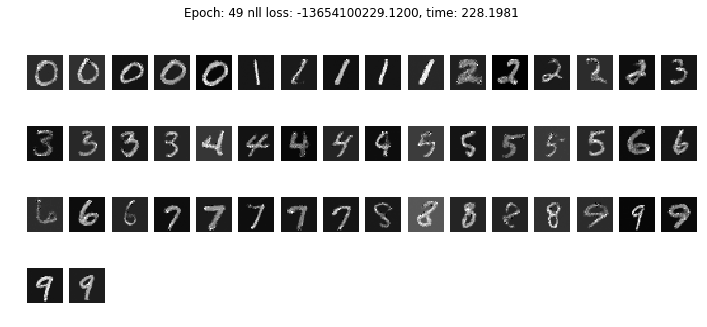

In [59]:
 z = prior_z.sample((50,))
oneHotLabels=torch.zeros((z.shape[0],10))
L=np.repeat(np.arange(10),5)
L=torch.tensor(L)
oneHotLabels[torch.arange(z.shape[0]),L]=1
oneHotLabels=oneHotLabels.to(device)
z=torch.cat([z,oneHotLabels],1)
x = flow.invert(z).cpu()
plotNumbersFromTensor(x[:,:-10],liczbaRysowanych=50)
plt.suptitle("Epoch: {} nll loss: {:.4f}, time: {:.4f}".format(
i,loss_acc / len(mnist_loaders["train"]) ,time.time()-t))
t=time.time()
plt.show()

In [58]:
torch.save(flow.state_dict(), "MNIST-0-1-modelNFUwarunkowany.pth".format(str(time.time())))